# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib, seaborn as sns

from astropy.io import votable, ascii
from scipy import interpolate

from custom_scripts.utilities import custom_iter, split_filters
from custom_scripts.xrt import XRT_lightcurve, get_BetaX
from custom_scripts.uncertainty import AsymmetricUncertainty, UncertaintyArray
from custom_scripts.fluxtools import effective_wavelength, lightcurve, simulate_spectrum

calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
alpha += alpha.lower()
numeric = ".0123456789"

In [10]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce/flatten MultiIndex
sGRBs = swift[swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2].copy() # filter catalog for GRBs with a valid T90 that is <2s

## Data parsing and cleanup

In [11]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
            'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]',
                      'UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([],dtype=float) # numerical magnitudes
lims = pd.Series([],dtype=object) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in numeric]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in numeric]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [12]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()

error 256; error 384; error 563; error 604; error 652; error 681; error 763; error 896; error 1091; error 1106; error 1172; error 1325; 

<ipython-input-12-9935b0563a4e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()


In [13]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [15]:
sGRBs.to_csv("./data/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
1,210413B,1043009,1.088,NaN,NaN,NaN,NaN,NaN,{'idx': 1},NaN,NaN,NaN,equal
7,210323A,1038247,1.12,85.20,-1.687,1.72358,89,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,17.7,brightest
27,210119A,1017711,0.06,NaN,NaN,NaN,NaN,NaN,{'idx': 27},"Fermi (GBM), MASTER-OAFA, Insight-HXMT/HE, GEC...",NaN,NaN,equal
35,201221D,1014037,0.16,87.42,NaN,1.28331,92,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,19.2,brightest
62,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.9,brightest


## Legacy and new data imports

In [20]:
BetaXData = pd.read_csv("./data/BetaXData.csv", header=None, names=["GRB","Beta_X","Beta_X_pos","Beta_X_neg"])
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]
BetaXData["Beta_X"] *= -1

OpticalData = pd.read_csv("./data/OpticalData.csv", header=None, names=["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"])
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
OpticalData["Time"] *= 60*60

filters = pd.read_csv("./data/FilterInfo.csv", header=None, names=["Observatory","Instrument","Filter","Wavelength","Frequency"])
OpticalData = OpticalData.merge(filters,how="left",on=["Observatory","Instrument","Filter"])

XRayData = pd.read_csv("./data/XRayData.csv", header=None, names=["GRB","Time","Exposure","F_x","e_F_x"])

In [21]:
new_sGRBs = sGRBs[[int(grb[:6]) > 150301 for grb in sGRBs["GRB"]]].copy() # Fong et al. 2015 has data through March 2015, i.e. 150301A

In [22]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
1,210413B,1043009,1.088,NaN,NaN,NaN,NaN,NaN,{'idx': 1},NaN,NaN,NaN,equal
7,210323A,1038247,1.12,85.20,-1.687,1.72358,89,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,17.70,brightest
27,210119A,1017711,0.06,NaN,NaN,NaN,NaN,NaN,{'idx': 27},"Fermi (GBM), MASTER-OAFA, Insight-HXMT/HE, GEC...",NaN,NaN,equal
35,201221D,1014037,0.16,87.42,NaN,1.28331,92,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,19.20,brightest
62,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.90,brightest
70,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.70,brightest
96,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 96}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest
105,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest
143,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest
173,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 173}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal


## Retrieve Swift XRT light curve and spectrum

In [23]:
burst = "160624A"
fluxdata = XRT_lightcurve(burst,swift)
Gamma, Gammapos, Gammaneg = get_BetaX(burst,swift)

Retrieved 160624A


Text(0, 0.5, 'Flux density')

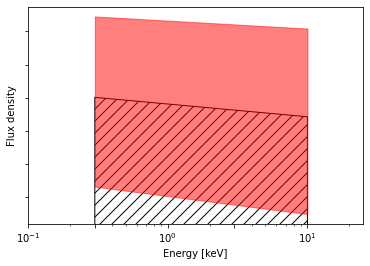

In [24]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma+Gammapos-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma-Gammaneg-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density")

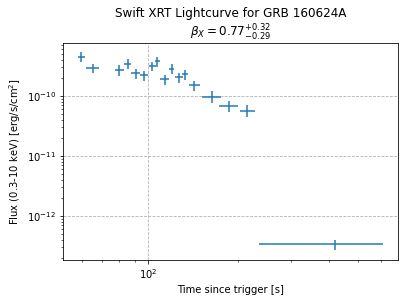

In [25]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gammaneg,Gammapos))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")
plt.show()

In [26]:
xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
for i in new_sGRBs.index:
    GRB_ID = new_sGRBs.loc[i,"GRB"]
    
    try:
        Gamma, Gammapos, Gammaneg = get_BetaX(GRB_ID,swift)
        fluxdata = XRT_lightcurve(GRB_ID,swift)
        xrt_data = xrt_data.append(fluxdata,ignore_index=True)

        new_sGRBs.loc[i,"Beta_X"] = Gamma - 1
        new_sGRBs.loc[i,"Beta_X_neg"] = Gammaneg
        new_sGRBs.loc[i,"Beta_X_pos"] = Gammapos
        #print(f"Found {GRB_ID} at index {i}: {Gamma, Gammapos, Gammaneg}")
        
    except:
        print("Failed to retrieve",GRB_ID)

Failed to retrieve 210413B
Retrieved 210323A
Failed to retrieve 210119A
Retrieved 201221D
Retrieved 201006A
Retrieved 200907B
Retrieved 200522A
Retrieved 200411A
Retrieved 191031D
Retrieved 190627A
Failed to retrieve 190610A
Failed to retrieve 190427A
Failed to retrieve 190326A
Retrieved 181123B
Retrieved 180805A
Retrieved 180727A
Failed to retrieve 180718A
Failed to retrieve 180715A
Retrieved 180402A
Retrieved 180204A
Retrieved 170728A
Retrieved 170524A
Retrieved 170428A
Failed to retrieve 170325A
Retrieved 170127B
Failed to retrieve 170112A
Retrieved 161104A
Retrieved 160927A
Retrieved 160821B
Failed to retrieve 160726A
Failed to retrieve 160714A
Retrieved 160624A
Retrieved 160601A
Retrieved 160525B
Retrieved 160411A
Retrieved 160408A
Retrieved 151229A
Failed to retrieve 151228A
Failed to retrieve 151205B
Retrieved 151127A
Retrieved 150831A
Retrieved 150728A
Failed to retrieve 150710A
Retrieved 150423A


## Converting x-ray flux values to spectral flux densities

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [60]:
for i in xrt_data.index:
    grb_id = xrt_data.loc[i,"GRB"]
    if grb_id not in new_sGRBs["GRB"].values:
        continue
    beta = AsymmetricUncertainty(float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X"]),
                                 float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_pos"]/1.645), # convert 90% conf to 1-sigma
                                 float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_neg"]/1.645)) # convert 90% conf to 1-sigma
    B = beta.value
    Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
    if B == 1:
        integral = np.log(10) - np.log(0.3)
    else:
        integral = (10**(1-B) - 0.3**(1-B))/(1-B)

    log_mean_energy = 10**np.mean((np.log10(0.3),np.log10(10)))

    dfdF = (log_mean_energy**(-B)*(1-B))/(10**(1-B)-0.3**(1-B))
    dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))
    pos_err = np.sqrt(dfdF**2*Fx.plus**2 + dfdB**2*beta.plus**2)
    neg_err = np.sqrt(dfdF**2*Fx.minus**2 + dfdB**2*beta.minus**2)
    result = Fx.value*log_mean_energy**(-B)/integral
    spectral_flux = AsymmetricUncertainty(result,pos_err,neg_err) # erg/s/cm^2/keV
    spectral_flux *= 1e23/241797944177033445 # convert to Jy
    xrt_data.loc[i,"SpecFlux"] = spectral_flux

for i in XRayData.index: # now add David's old data in the same format
    GRB = XRayData.loc[i,"GRB"][3:]
    t = XRayData.loc[i,"Time"]
    tpos = tneg = XRayData.loc[i,"Exposure"]/2
    flux = XRayData.loc[i,"F_x"]/1000000 # uJy to Jy
    fluxpos = fluxneg = XRayData.loc[i,"e_F_x"]/1000000
    newrow = dict(zip(xrt_data.columns, [t,tpos,tneg,np.nan,np.nan,np.nan,GRB,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
    xrt_data = xrt_data.append(newrow, ignore_index=True)

<ipython-input-60-df896d2dd079>:17: RuntimeWarning: invalid value encountered in double_scalars
  dfdF = (log_mean_energy**(-B)*(1-B))/(10**(1-B)-0.3**(1-B))
<ipython-input-60-df896d2dd079>:18: RuntimeWarning: invalid value encountered in double_scalars
  dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))
<ipython-input-60-df896d2dd079>:18: RuntimeWarning: divide by zero encountered in double_scalars
  dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))


## Load new optical data

In [121]:
new_optical = pd.read_excel("./data/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells
new_optical.drop(new_optical[new_optical["Magnitude"]=="spectroscopy only"].index,axis=0,inplace=True)
new_optical["mag_w_err"] = [AsymmetricUncertainty(mag,err,err) if isinstance(err,(float,int)) else AsymmetricUncertainty(mag,np.inf,0) for mag,err in new_optical[["Magnitude","Mag error"]].values]

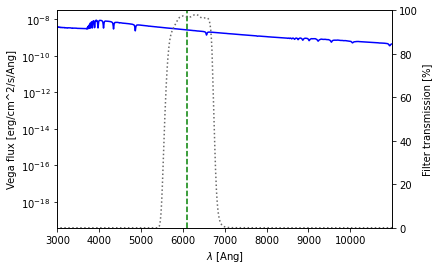

6100.363120460687

In [65]:
I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt")
rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
rprime_filter.columns = ["Wavelength","Transmission"]
rprime_filter["Wavelength"] *= 10

effective_wavelength(rprime_filter,show_plot=True)

## Correcting for extinction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

In [66]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"]) # function that takes a wavelength [Ang] and returns the corresponding R_b value

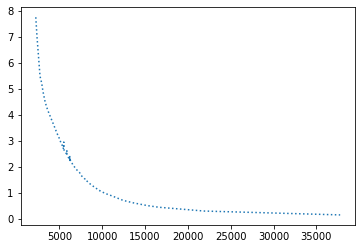

In [67]:
RbTable.sort_values(by="lambda_eff",inplace=True)
plt.plot(RbTable.lambda_eff, RbTable.R_b, ":")

In [122]:
for i in new_optical.index:    
    try:
        new_optical.loc[i,"Extinction"] = Rb(new_optical.loc[i,"λ_eff"])*new_optical.loc[i,"E(B-V)"]
    except ValueError:
        pass

## Converting optical magnitudes to spectral flux densities

In [123]:
new_optical["Flux (Jy)"] = 3631*10**(-(new_optical["mag_w_err"]-new_optical["Extinction"])/2.5) # AB mag = 0 at F_nu = 3631 Jy

all_optical = new_optical.copy()

for i in OpticalData.index:
    GRB = OpticalData.loc[i,"GRB"]
    obs = OpticalData.loc[i,"Observatory"]
    inst = OpticalData.loc[i,"Instrument"]
    filt = OpticalData.loc[i,"Filter"]
    time = OpticalData.loc[i,"Time"]
    lambda_eff = OpticalData.loc[i,"Wavelength"]*10
    flux = OpticalData.loc[i,"F_o"]/1000000
    fluxpos = fluxneg = OpticalData.loc[i,"e_F_o"]/1000000
    newrow = dict(zip(all_optical.columns, [GRB,np.nan,obs,inst,filt,lambda_eff,time,np.nan,np.nan,"Fong",
                                            np.nan,np.nan,np.nan,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
    all_optical = all_optical.append(newrow, ignore_index=True)

## Putting it all together

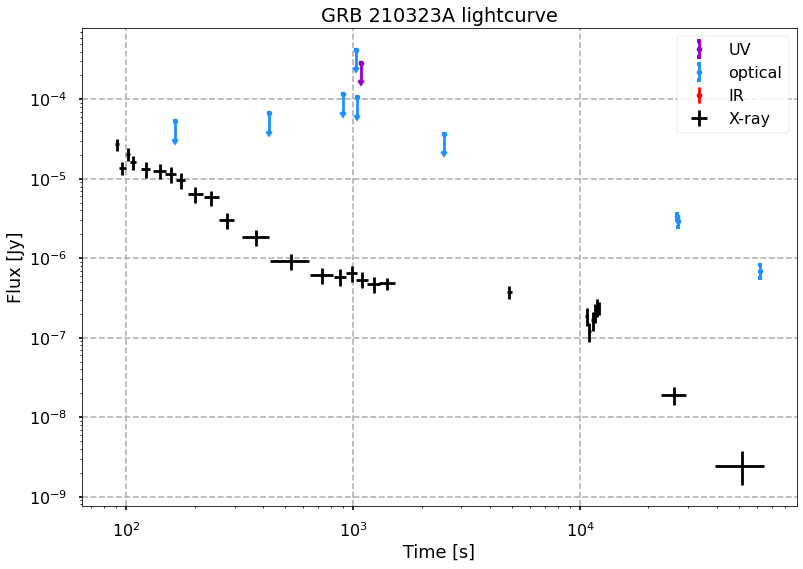

In [133]:
grb = "210323A"

fig, ax = plt.subplots()

subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()

subset.loc[:,"band"] = ["UV" if band<3000 else "IR" if band>8000 else None if pd.isna(band) else "optical" for band in subset["λ_eff"]]
colors = {"UV":"darkviolet","optical":"dodgerblue","IR":"red"}
for band,color in colors.items():
    subsubset = subset[subset["band"]==band]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
    ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                marker=".",linestyle="",color=color,label=f"{band}",capthick=4,
                yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]])

subset = xrt_data.loc[xrt_data["GRB"]==grb]
neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                      xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                      linestyle="",capthick=0,color="k",label="X-ray")

ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
ax.legend()
ax.grid(linestyle="--")

In [127]:
display(all_optical)
display(xrt_data)

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
0,210413B,1043009,GECKO,LOAO,B,4380.74,185459.217,20.78,inf,GCN 29825,0.010,0.035828,"20.78 (+inf, -0.0)","1.829605792911923e-05 (+0.0, -inf)"
1,210413B,1043009,GECKO,LOAO,V,5445.79,186062.483,20.347,inf,GCN 29825,0.010,0.027438,"20.347 (+inf, -0.0)","2.7052138348248542e-05 (+0.0, -inf)"
2,210413B,1043009,GECKO,LOAO,R,6414.20,186666.417,19.594,inf,GCN 29825,0.010,0.021711,"19.594 (+inf, -0.0)","5.384069702947088e-05 (+0.0, -inf)"
3,210413B,1043009,GECKO,LOAO,I,7978.80,187263.350,19.293,inf,GCN 29825,0.010,0.015373,"19.293 (+inf, -0.0)","7.062776069562384e-05 (+0.0, -inf)"
4,210323A,1038247,Gemini North,GMOS,r,6224.52,62208.000,24.6,0.2,GCN 29720,0.131,0.297948,24.6 ± 0.2,6.905664110119469e-07 ± 1.272070338974806e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,150101B,NaN,Gemini-S,GMOS,r,6330.00,925200.000,NaN,NaN,Fong,NaN,NaN,NaN,7.6e-07 ± 0.0
1070,150101B,NaN,TNG,NICS,J,12790.00,1256400.000,NaN,NaN,Fong,NaN,NaN,NaN,3.98e-06 ± 0.0
1071,150101B,NaN,VLT,HAWK-I,H,16200.00,1296000.000,NaN,NaN,Fong,NaN,NaN,NaN,1.4499999999999999e-06 ± 0.0
1072,150101B,NaN,Magellan/Baade,IMACS,r,6650.00,2498400.000,NaN,NaN,Fong,NaN,NaN,NaN,5.3e-07 ± 0.0


,Time,Tpos,Tneg,Flux,Fluxpos,Fluxneg,GRB,SpecFlux
0,90.691,1.772,-1.822,4.162478e-10,7.358302e-11,-7.358446e-11,210323A,2.723651204277404e-05 ± 4.904761274793357e-06
1,95.882,3.251,-3.419,2.102652e-10,3.838906e-11,-3.838998e-11,210323A,1.3758371770631024e-05 ± 2.5559588258795893e-06
2,101.302,2.183,-2.169,3.159472e-10,5.947158e-11,-5.947350e-11,210323A,2.0673502729757194e-05 ± 3.955634376822191e-06
3,106.615,2.334,-3.130,2.458731e-10,4.773577e-11,-4.773773e-11,210323A,1.6088318360241458e-05 ± 3.1719811063055207e-06
4,121.846,9.342,-5.702,2.036823e-10,4.575964e-11,-4.575964e-11,210323A,1.3327629993240761e-05 ± 3.0289737849755426e-06
...,...,...,...,...,...,...,...,...
6993,60000.000,9000.000,9000.000,NaN,NaN,NaN,150101A,1e-08 ± 0.0
6994,690000.000,7500.000,7500.000,NaN,NaN,NaN,150101B,1.1e-08 ± 1.1000000000000001e-09
6995,3400000.000,7500.000,7500.000,NaN,NaN,NaN,150101B,1.9e-09 ± 4.7e-10
6996,8300.000,6000.000,6000.000,NaN,NaN,NaN,150120A,3.1e-08 ± 0.0


## Match data points in time

In [128]:
max_dt = 0.1
nu_x = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18 # xray frequency [m]
results = pd.DataFrame(columns=["GRB","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in all_optical.index: # for each optical data point
    t_o = all_optical.loc[i_o,"Time (s)"] # optical observation time
    F_o = all_optical.loc[i_o,"Flux (Jy)"] # optical flux
    nu_o = 299792458/float(all_optical.loc[i_o,"λ_eff"]/1e10) # optical frequency [m]
    for i_x in xrt_data[xrt_data["GRB"]==all_optical.loc[i_o,"GRB"]].index: # for each x-ray data point on this GRB
        t_x = float(xrt_data.loc[i_x,"Time"]) # x-ray observation time
        dt = np.abs(t_o-t_x)/t_o # time difference
        if dt <= max_dt: # if time separation is allowable
            F_x = xrt_data.loc[i_x,"SpecFlux"]
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if pd.notna(Beta_ox):
                results = results.append({"GRB":all_optical.loc[i_o,"GRB"], "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)
        else: # if data points don't match
            pass

In [129]:
# get the previously retreived x-ray spectral indices for comparison

all_beta_x = pd.concat((new_sGRBs[["GRB","Beta_X","Beta_X_pos","Beta_X_neg"]],BetaXData)) # table of all xray spectral indices
results = results.merge(all_beta_x,on="GRB",how="left") # match by GRB ID
results["B_x"] = [AsymmetricUncertainty(*results.loc[i,["Beta_X","Beta_X_pos","Beta_X_neg"]]) for i in results.index] # construct objects
results.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'],axis=1,inplace=True) # discard superfluous columns

# add flag columns for darkness by both methods
for i in results.index: # '<<' operator is overloaded for use with AsymmetricUncertainty class
    results.loc[i,"Jak_dark"] = (results.loc[i,"B_ox"] << 0.5)
    results.loc[i,"vdH_dark"] = (results.loc[i,"B_ox"] << results.loc[i,"B_x"]-0.5)

results.sort_values(by="GRB",ascending=False)

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark
0,210323A,0.034537,4.734539e+14,2.906679197299785e-06 ± 4.0157257138910314e-07,4.188080e+17,1.9272753201566128e-08 ± 5.059993676717163e-09,"0.7392764117158406 (+0.043696197611704395, -0....","0.72 (+0.2, -0.19)",False,False
10,210323A,0.016965,1.116903e+15,"0.000288885003598624 (+0.0, -inf)",4.188080e+17,5.403372361761994e-07 ± 1.2319565677707346e-07,"1.0598526341809642 (+0.03842604669772694, -inf)","0.72 (+0.2, -0.19)",False,False
1,210323A,0.040762,7.715315e+14,"5.355511149873595e-05 (+0.0, -inf)",4.188080e+17,1.155364738228027e-05 ± 2.6209679545568475e-06,"0.24357013207712835 (+0.035986353170497205, -inf)","0.72 (+0.2, -0.19)",True,False
17,210323A,0.053648,NaN,"nan (+nan, -nan)",4.188080e+17,1.3758371770631024e-05 ± 2.5559588258795893e-06,"nan (+nan, -nan)","0.72 (+0.2, -0.19)",False,False
16,210323A,0.003396,NaN,"nan (+nan, -nan)",4.188080e+17,2.723651204277404e-05 ± 4.904761274793357e-06,"nan (+nan, -nan)","0.72 (+0.2, -0.19)",False,False
...,...,...,...,...,...,...,...,...,...,...
315,050709,0.018359,5.382270e+14,3.6e-07 ± 0.0,4.188080e+17,5.9e-09 ± 0.0,0.617578667886267 ± 0.0,1.24 ± 0.35,False,False
316,050709,0.018359,5.382270e+14,3.6e-07 ± 0.0,4.188080e+17,5.9e-09 ± 0.0,0.617578667886267 ± 0.0,1.24 ± 0.35,False,False
317,050709,0.018359,5.382270e+14,3.6e-07 ± 0.0,4.188080e+17,5.9e-09 ± 0.0,0.617578667886267 ± 0.0,1.24 ± 0.35,False,False
299,050709,0.012972,5.382270e+14,6.4e-07 ± 7e-08,4.188080e+17,1.5e-09 ± 0.0,0.9097349351781538 ± 0.016430351407324628,1.24 ± 0.35,False,False


In [130]:
dark = results.loc[results["Jak_dark"] | results["vdH_dark"],:]
for GRB in dark["GRB"].unique():
    print(GRB,dark["GRB"].tolist().count(GRB))

210323A 2
200411A 1
191031D 1
181123B 1
180727A 1
180204A 2
160821B 13
160624A 2
151229A 4
150831A 7
060121 51
060313 39
070707 6
100117A 3
111020A 9
130912A 12


In [82]:
# only accept the closest in time for each GRB
close_times = dark.copy()
for grb_id in dark["GRB"].unique():
    working = dark[dark["GRB"]==grb_id]
    closest_time = working["dt%"].min()
    close_times.drop(working[working["dt%"] != closest_time].index, axis=0, inplace=True)
    
darkest_times = dark.copy()
for grb_id in dark["GRB"].unique():
    working = dark[dark["GRB"]==grb_id]
    darkest_beta = working["B_ox"].min()
    darkest_times.drop(working[working["B_ox"] != darkest_beta].index, axis=0, inplace=True)

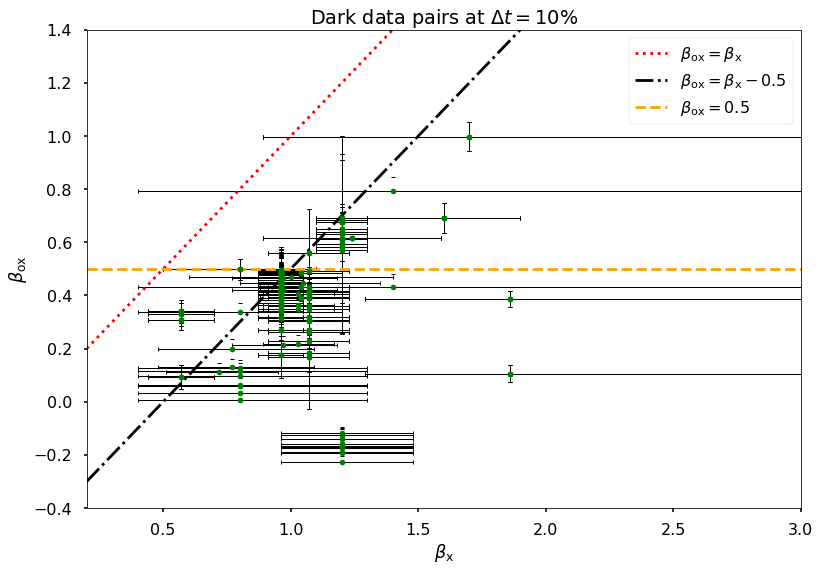

In [100]:
b_ox = [b.value for b in dark["B_ox"]]
oxplus = [b.plus for b in dark["B_ox"]]
oxminus = [b.minus for b in dark["B_ox"]]
b_x = [b.value for b in dark["B_x"]]
xplus = [b.plus for b in dark["B_x"]]
xminus = [b.minus for b in dark["B_x"]]
bursts = [grb for grb in dark["GRB"]]
plt.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],linestyle="",marker=".",
             mfc="g",mec="g",ecolor="k",elinewidth=1,capthick=1)
x = np.linspace(0.2,3,50)
y = np.linspace(-.4,1.4,50)
plt.plot(x,x,"r:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
plt.plot(x,x-.5,"k-.",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
plt.plot(x,[.5]*len(x),linestyle="--",color="orange",label=r"$\beta_\mathrm{ox}=0.5$")
plt.xlim(.2,3)
plt.xlabel(r"$\beta_\mathrm{x}$")
plt.ylim(-.4,1.4)
plt.ylabel(r"$\beta_\mathrm{ox}$")
plt.title("Dark data pairs at $\Delta t=10\%$")
plt.legend()
plt.show()

GRB                                                 160624A
dt%                                               0.0742895
nu_o                                            7.71532e+14
F_o                     2.2469077263974652e-05 (+0.0, -inf)
nu_x                                            4.18808e+17
F_x           6.43563651729827e-06 ± 1.4683568734923836e-06
B_ox        0.1985597727235074 (+0.03610621145682231, -inf)
B_x                                     0.77 (+0.32, -0.29)
vdH_dark                                               True
Jak_dark                                               True
Name: 210, dtype: object

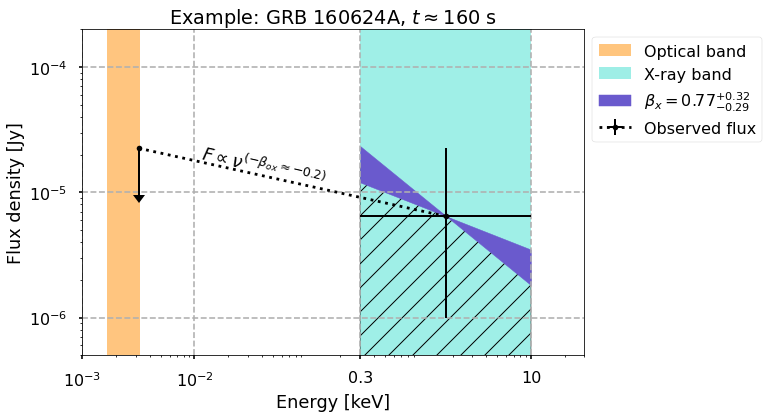

In [97]:
display(results[results["GRB"]=="160624A"].iloc[1,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)

E_o = results.loc[210,"nu_o"]*6.62607015e-34/1.6021773E-16
E_x = results.loc[210,"nu_x"]*6.62607015e-34/1.6021773E-16
F_o = results.loc[210,"F_o"]
F_x = results.loc[210,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x],[F_o.value,F_x.value],xerr=[(0,E_x-0.3),(0,10-E_x)],
             yerr=[(0.000013,F_x.value-1e-6),(0,F_o.value-F_x.value)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label=r"$\beta_x=0.77_{-0.29}^{+0.32}$")
plt.text(1.1e-2,1.1e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.2})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(1e-3,30)
plt.ylim(5e-7,2e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 160624A, $t\approx160$ s")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("160624A.png",bbox_inches="tight",dpi=300)